# Introduction to Machine Learning

In [214]:
# Import Libraries

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Decision Trees
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn import tree 

# Gradient Boosting
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

# Grid Search
from sklearn.model_selection import GridSearchCV

In [89]:
# Read in the dataset and do some quick data cleanup.
dat = pd.read_csv('D:/Documents/SpringBoard/capstone-1/datasets/final_files/combined/'
                  'filled/jackknifed_counts.csv', 
                 parse_dates=['Date']) 

dat['Receiver_D'] = dat['Receiver_D'].astype('category') # turn receiver D into a category
    # for analyses and plotting
dat['Year'] = dat['Year'].astype('category') # turn into a category
dat['Transmitter'] = pd.to_numeric(dat['Transmitter'], errors='coerce') # and make
    # sure that the 'Transmitter' (shark density) is numeric
    
dat['Receiver_D'] = dat['Receiver_D'].cat.remove_unused_categories()

In [90]:
dat['presence'] = dat['Transmitter'].copy() # make a copy of the transmitter data
dat['presence'].values[dat['presence'].values > 1] = 1 # and convert transmitter vals > 1
    # to 1
dat['presence'] = dat['presence'].astype('category') # convert to category so
    # that we can run some t-tests
    
orig_dat = dat.copy() # to save in case we decide that we don't need to do dummies
    # to run a model (like is described in Decision Trees)

In [91]:
# Separate the data into predictors and response variables
response = dat[['presence']].copy()
dat = dat[['Zone', 'Receiver_D', 'DepthGradient', 'TempC', 'Sal', 'ChlA', 'MoonPhase', 'Month', 'Year']].copy()

In [92]:
# Get dummy variables and drop the original ones
zone = pd.get_dummies(dat.loc[:,'Zone']) # get dummies for zone
zone.columns = ['Zone_'+str(zone.columns[i]) for i in range(len(zone.columns))]
    # change column names so that they don't get confused with other values that may be
    # similar
dat[zone.columns[1:]] = zone.iloc[:,1:] # add the columns to dat and remove 1 to avoid
    # redundancy

lunar = pd.get_dummies(dat.loc[:,'MoonPhase']) # get dummies for lunar phase
dat[lunar.columns[1:]] = lunar.iloc[:,1:] # add columns and remove 1

month = pd.get_dummies(dat.loc[:,'Month']) # get dummies for month
month.columns = ['Month_'+str(month.columns[i]) for i in range(len(month.columns))]
    # change column names so they can't be confused with other factors
dat[month.columns[1:]] = month.iloc[:,1:] # add columns and remove 1

year = pd.get_dummies(dat.loc[:, 'Year']) # get dummies for year
year.columns = ['Year_'+str(year.columns[i]) for i in range(len(year.columns))]
    # change column names so they can't be confused with other factors
dat[year.columns[1:]] = year.iloc[:,1:] # add columns and remove 1

receivers = pd.get_dummies(dat.loc[:, 'Receiver_D']) # get dummies for receiver density
receivers.columns = ['ReceiverD_'+str(receivers.columns[i]) for i in range(len(receivers.columns))]
    # change column names so they can't be confused with other factors
dat[receivers.columns[1:]] = receivers.iloc[:,1:] # add columns and remove 1

# Clean up
dat = dat.drop(['Zone', 'MoonPhase', 'Month', 'Year', 'Receiver_D'], axis=1) 
    # drop the original columns now that we have the dummies set up

In [113]:
# Decision Trees...
# Split data appropriately
X = dat
y = response

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33) 

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9858641975308642


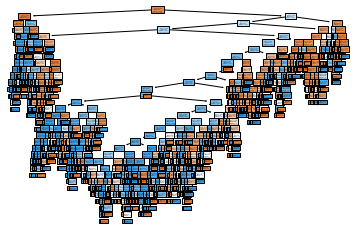

In [121]:
tree.plot_tree(clf, filled=True) # plot full decision tree
plt.show() # show plot

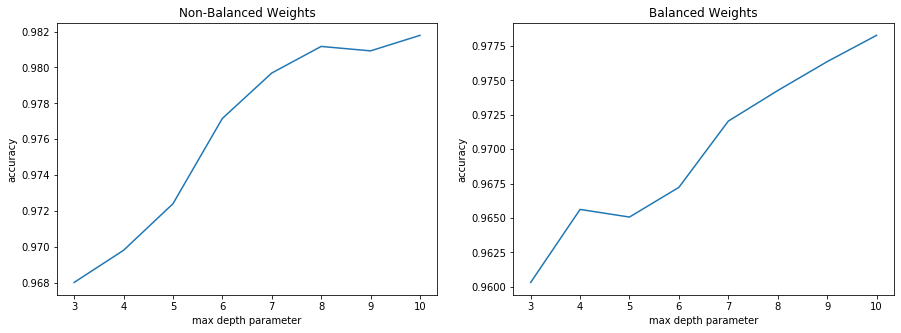

In [190]:
# Yikes. See which max depth (and balance level) comes up with the best accuracy

depths = range(3,11) # do a range between 3 and 11

accuracy_notbal = pd.DataFrame() # save accuracy for non-balanced data
accuracy_bal = pd.DataFrame() # save accuracy for balanced data

# Iterate through depths
for depth in depths: 
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
        # build model, switch criterion to entropy so that we can see how much more
        # information we get from each node

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    # Save the accuracy for the non-balanced model
    temp = pd.DataFrame({'max_depth':depth, 'accuracy': metrics.accuracy_score(y_test, y_pred)}, index=[0])
    accuracy_notbal = accuracy_notbal.append(temp, ignore_index=True)
    
    # Restart with balance parameter
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth, class_weight='balanced')
    
    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    # Save the results for the balanced model
    temp = pd.DataFrame({'max_depth':depth, 'accuracy': metrics.accuracy_score(y_test, y_pred)}, index=[0])
    accuracy_bal = accuracy_bal.append(temp, ignore_index=True)

# Plot the results next to each other
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5)) # initialize plot

# Plot the non-balanced model accuracy vs depth
ax1.plot(accuracy_notbal['max_depth'], accuracy_notbal['accuracy'])
ax1.set_xlabel('max depth parameter')
ax1.set_ylabel('accuracy')
ax1.set_title('Non-Balanced Weights')

# Plot the balanced model accuracy vs depth
ax2.plot(accuracy_bal['max_depth'], accuracy_bal['accuracy'])
ax2.set_xlabel('max depth parameter')
ax2.set_ylabel('accuracy')
ax2.set_title('Balanced Weights')

# Show the plot
plt.show()

It looks like these are two very different results. When the data aren't balanced, we don't really get a plateau in accuracy until a max depth of 7 or 8, which will be hard to interpret. With a balanced model, we see that the highest jump in accuracy is with a max depth of 3-4... which is easier to interpret. However, there really is no plateau in this instance.

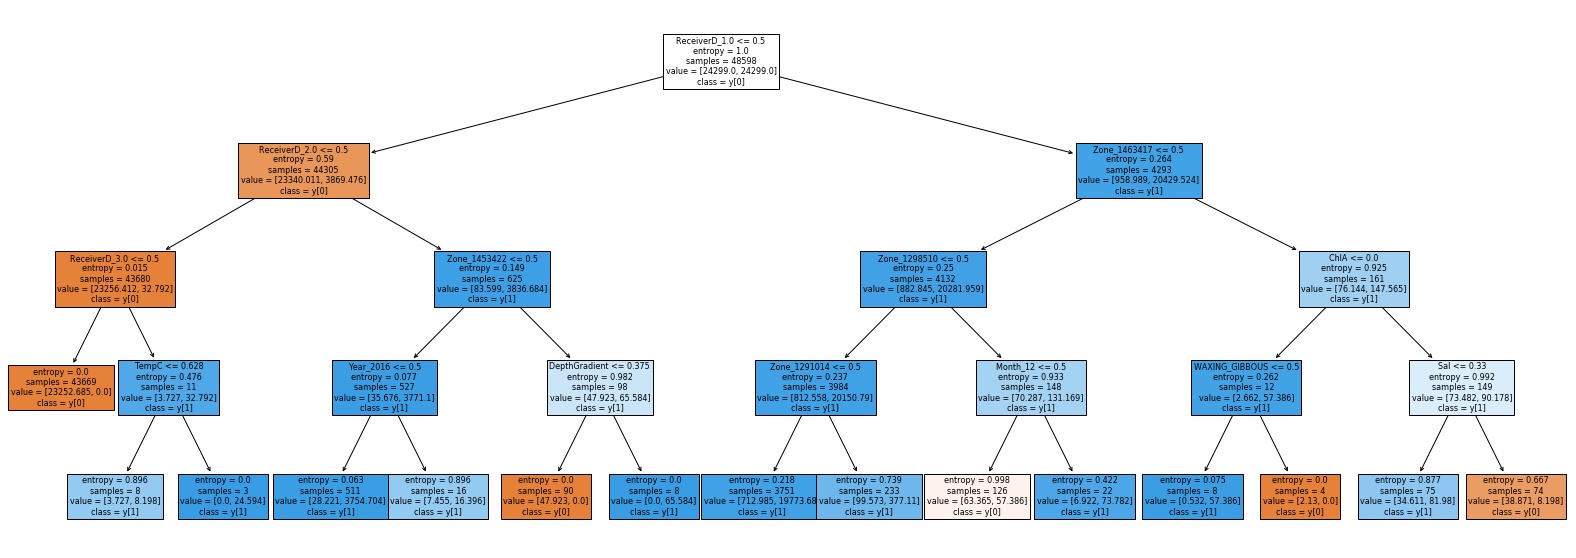

In [206]:
# Let's plot the decision tree for a balanced model with a max depth of 4
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4, class_weight='balanced')

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
    
# Plot
plt.figure(figsize=(28,10))
tree.plot_tree(clf, filled=True, fontsize=8, class_names=True, feature_names=X.columns)  
plt.show()

In [201]:
# Gradient Boosting
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33) 

# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Do for a variety of learning rates
learning_rates = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

# Iterate through learnings rates
for learning_rate in learning_rates:
    gb_clf = GradientBoostingClassifier(learning_rate=learning_rate, random_state=33)
    gb_clf.fit(X_train, y_train.values.ravel())

    # Print the accuracy for the training and the test data.
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.982
Accuracy score (validation): 0.982
Learning rate:  0.075
Accuracy score (training): 0.983
Accuracy score (validation): 0.983
Learning rate:  0.1
Accuracy score (training): 0.984
Accuracy score (validation): 0.983
Learning rate:  0.25
Accuracy score (training): 0.987
Accuracy score (validation): 0.986
Learning rate:  0.5
Accuracy score (training): 0.992
Accuracy score (validation): 0.987
Learning rate:  0.75
Accuracy score (training): 0.939
Accuracy score (validation): 0.934
Learning rate:  1
Accuracy score (training): 0.958
Accuracy score (validation): 0.960


It seems like the data are performing pretty well until a learning rate of 0.75... Is this normal? To have such high accuracies? I thought we were expecting to get low prediction power?

In [211]:
# Grid Search for gradient boosting
parameters = {'learning_rate':[0.075, 0.1, 0.25, 0.5, 0.75], 'n_estimators':[10, 50, 100], 
             'max_depth':[3,6,8]}
    # Set parameters
gb = GradientBoostingClassifier()
    # set classifier
clf = GridSearchCV(gb, parameters, cv=5)
    # run grid search with a fold of 5
clf.fit(X, y.values.ravel()) # fit to the data

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [213]:
# Produce the best parameters
clf.best_params_

{'learning_rate': 0.075, 'max_depth': 3, 'n_estimators': 100}

Above suggests that we should use a learning rate of 0.075, a max depth of 3 and n_estimators as 100. Does this make sense, even though it seems like the highest values of training and testing accuracy are actually at a learning rate of 0.25?